<a href="https://colab.research.google.com/github/DENGCPU/TensorFlow-Study/blob/main/%E5%AE%98%E7%BD%91demo2_%E6%96%87%E6%9C%AC%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 使用IMDB数据集, 将电影评论分为正面 or 负面评价

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

print(tf.__version__)

# 下载数据集
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
# 下载到本地aclImdb_v1中，并解压
dataset = tf.keras.utils.get_file('aclImdb_v1',url,untar=True,cache_dir='.',cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb')

2.15.0
84125825/84125825 [==============================] - 19s 0us/step


In [3]:
os.listdir(dataset_dir)

['README', 'imdbEr.txt', 'test', 'imdb.vocab', 'train']

In [4]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['unsupBow.feat',
 'pos',
 'urls_unsup.txt',
 'urls_pos.txt',
 'neg',
 'urls_neg.txt',
 'unsup',
 'labeledBow.feat']

In [5]:
# 其中/train/pos 和/ train/neg 中包含许多文本文件
# 查看其中一条电影评论
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
 # 使用text_dataset_from_directory工具准备数据集
 # 首先把IMDB数据集中的其他无用文件夹移除
 remove_dir = os.path.join(train_dir,'unsup')
 # 删除目录及所有子目录和文件
 shutil.rmtree(remove_dir)

 # IMDB有训练集和测试集，但是缺少验证集
 # 使用valition_split参数，使用80:20拆分训练数据创建验证集
 batch_size=32
 seed=42

# seed是随机数生成器的种子，用于保证多次运行text_dataset_from_directory时
# 会产生相同的随机数序列，且验证拆分和训练拆分不会重叠
 raw_train_ds = tf.keras.utils.text_dataset_from_directory(
     'aclImdb/train',
     batch_size=batch_size,
     validation_split=0.2,
     subset='training',
     seed=seed
 )

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [7]:
# 查看一些样本
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('Review',text_batch.numpy()[i])
    print('Label',label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [8]:
# 标签0或1，查看他们和电影评价正面或负面的对应关系
print('Label 0 corresponds to',raw_train_ds.class_names[0])
print('Label 1 corresponds to',raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [9]:
# 验证集 - 5000条
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [10]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [13]:
# 使用tf.keras.layers.TextVectorization对数据进行标准化、词例化、向量化

# 1.标准化: 移除文本的标点符合或HTML元素等
# 2.词例化: 将字符串分割成词例
# 3.向量化：将词例转为数字，以便输入到神经网络

def custom_standardization(input_data):
  lowercase=tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
  # 将stripped_html中的所有标点符号替换为空字符串（即删除）
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

# 创建一个TextVectorization层
max_features=10000
sequence_length=250

vectorize_layer=layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    # 以便为每个词例创建唯一的整数索引
    output_mode='int',
    output_sequence_length=sequence_length
)

# 调用adapt使预处理层的状态适合整数集，构建字符串到整数的索引
# 注意仅使用训练数据
train_text = raw_train_ds.map(lambda x,y:x) #从训练集中提取所有的特征x，忽略y标签
vectorize_layer.adapt(train_text)

def vectorize_text(text,label):
  # 在张量的最后一个维度之后增加1个维度
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text), label

#从数据集中检索一批（32条评论和标签）
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review,first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [14]:
print('1111整数对应的词例-->',vectorize_layer.get_vocabulary()[1111])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1111整数对应的词例--> appreciate
Vocabulary size: 10000


In [15]:
# 将TextVectorization 层应用与训练数据集、验证集、测试集
train_ds= raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# 配置数据集提高性能
# prefetch() 会在训练时将数据处理和模型执行重叠
# cache() 将数据保存在内存中
AUTOTUNE = tf.data.AUTOTUNE
# TensorFlow 会基于系统的硬件配置和当前的工作负载来自动调整线程数
# 使用 AUTOTUNE 来确定最佳的预取缓冲区大小。
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 创建模型
embedding_dim=16 #嵌入向量的维度

model = tf.keras.Sequential([
    # 嵌入层，将整数索引转为固定大小的嵌入向量
    layers.Embedding(max_features+1, embedding_dim),
    # 丢弃层，0.2为丢弃率，随机将输入张量的某些元素设置为0，放置过拟合
    layers.Dropout(0.2),
    # 全局平均池化层，对时间维度(即序列长度)上的每个嵌入向量取平均值，得到一个固定大小输出向量
    layers.GlobalAveragePooling1D(),
    # 再次使用丢弃层防止过拟合
    layers.Dropout(0.2),
    # 全连接层（密集层、输出层）：对输入张量进行线性变换，1是输出神经元数量
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [16]:
model.compile(loss = losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 7s 10ms/step - loss: 0.6635 - binary_accuracy: 0.6946 - val_loss: 0.6137 - val_binary_accuracy: 0.7726
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5468 - binary_accuracy: 0.8023 - val_loss: 0.4966 - val_binary_accuracy: 0.8230
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4430 - binary_accuracy: 0.8464 - val_loss: 0.4189 - val_binary_accuracy: 0.8466
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3775 - binary_accuracy: 0.8671 - val_loss: 0.3727 - val_binary_accuracy: 0.8612
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3343 - binary_accuracy: 0.8795 - val_loss: 0.3443 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3039 - binary_accuracy: 0.8895 - val_loss: 0.3254 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 6s 10ms/s

In [17]:
# 评估模型
loss, accuracy = model.evaluate(test_ds)
print('Loss:', loss)
print('Accuracy:',accuracy)

782/782 [==============================] - 9s 12ms/step - loss: 0.3103 - binary_accuracy: 0.8733
Loss: 0.3103379011154175
Accuracy: 0.8733199834823608


In [19]:
# 创建准确率和损失随时间变化的图表
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

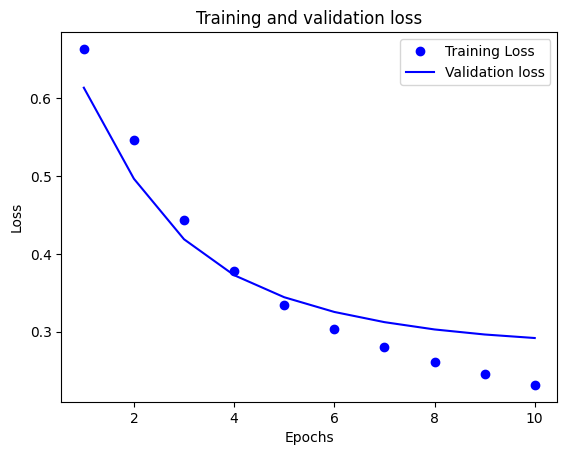

In [21]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)
# bo指蓝色的点
plt.plot(epochs,loss,'bo',label='Training Loss')
# b指蓝色实线
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

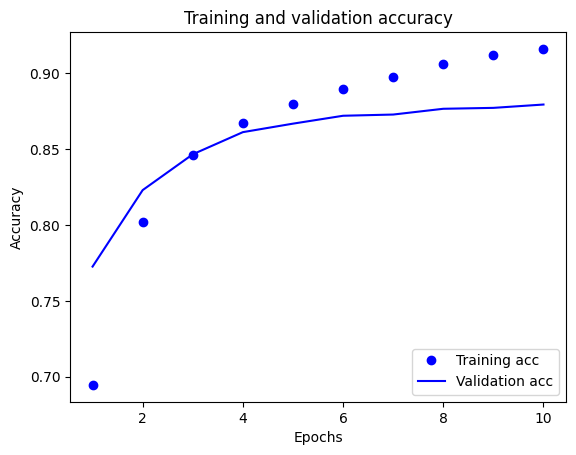

In [23]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [24]:
# 导出模型

# 上述代码中，对所有数据集应用了TextVectorization
# 如果想要模型直接能处理原始字符串，可以在模型中包含TextVectorization层

# 使用刚刚训练的权重创建一个新模型
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)
#测试下新模型
loss,accuracy=export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 4ms/step - loss: 0.3103 - accuracy: 0.8733
0.8733199834823608


In [25]:
# 对新样本进行预测
examples = [
    'The moive was great',
    'The moive is okay',
    'The movie is terrible'
]
export_model.predict(examples)

1/1 [==============================] - 0s 197ms/step


array([[0.6136959 ],
       [0.4630705 ],
       [0.37575135]], dtype=float32)